# Recurrent Neural Network Project

#### For the course Complete Tensorflow 2 and Keras Deeplearning Bootcamp

We will use the [Frozen Dessert Production dataset](https://fred.stlouisfed.org/series/IPN31152N) and create a RNN model to predict future values. The dataset has a industrial production (IP) index values per month. The IP measures the real output of all relevant establishments located in the United States.

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data exploration

In [2]:
ip_df = pd.read_csv("data/Frozen_Dessert_Production.csv")
ip_df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [3]:
ip_df = ip_df.set_index("DATE")
ip_df.columns = ["IP"]

ip_df.head()

,IP
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
print(f"Date min: {ip_df.index.min()}")
print(f"Date max: {ip_df.index.max()}")


Date min: 1972-01-01
Date max: 2019-09-01


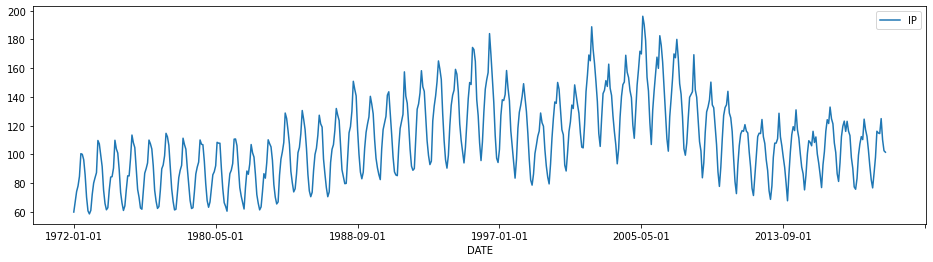

In [5]:
ip_df.plot(figsize=(16, 4));

## Train and Test Split

In [6]:
# How many rows do we have

len(ip_df)

573

In [7]:
# Define a test size
# In this case we decide that the test size is the last two years, 24 months

test_size = 24
test_index = len(ip_df) - test_size

In [8]:
# Now we define the train and test split

train_set = ip_df.iloc[:test_index]
test_set = ip_df.iloc[test_index:]

In [9]:
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 549
Test set size: 24


## Scaling the data

In [10]:
# We will scale the data between 0 and 1 using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_set = scaler.fit_transform(train_set)
scaled_test_set = scaler.transform(test_set)

## Time Series Generator

We will create a TimeSeriesGenerator that will basically embed the time series inside a TimeSeriesGenerator object that will later directly be feed inside the network.

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# length of each sample used to train our network. In this case, with 18 (months) we capture a full year seasonality
length = 18

# batch size represent the number of output sub-series per batch
train_generator = TimeseriesGenerator(data=scaled_train_set, targets=scaled_train_set, length=length, batch_size=1)

## Creation of the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# We only have one feature
n_features = 1 

model = Sequential()

# as a Dense layer with 100 dimensions will have 100 neurons, LSTM(100) will be a layer of 100 'smart neurons'
# where the output will be a vector of 100 dimensions
model.add(LSTM(units=100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1)) # output layer with only 1 output

# compilation
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Creating a TimeSeriesGenerator for the validation set

validation_generator = TimeseriesGenerator(data=scaled_test_set, targets=scaled_test_set, length=length, batch_size=1)

In [15]:
# Let´s create an EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=2)

In [16]:
# Let´s fit the model to the train generator; and use validation_generator to validate and be able to use early_stop

model.fit_generator(generator=train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20


C:\Users\ROCIO~1.HUB\AppData\Local\Temp/ipykernel_33620/3999719263.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])


531/531 [==============================] - 4s 6ms/step - loss: 0.0275 - val_loss: 0.0033
Epoch 2/20
531/531 [==============================] - 2s 5ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 3/20
531/531 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0082


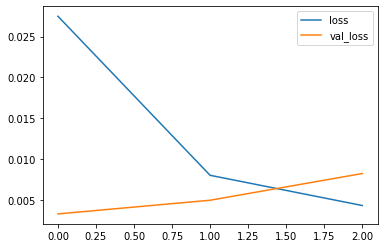

In [17]:
# Plotting the loss over training

loss = pd.DataFrame(model.history.history)
loss.plot();

## Evaluation of the model over test data

Let´s forecast new predictions and see how the model is behaving.

In [18]:
test_predictions = []

# we need these last 24 months to predict some new value (24 since that the length we define before)
first_evaluation_batch = scaled_train_set[-length:]

# one time series per batch (the 1 correspond to the batch size)
current_batch = first_evaluation_batch.reshape((1, length, n_features))

# we are only forecasting over the test set
for i in range(len(test_set)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_prediction = model.predict(current_batch)[0]
    
    # store the prediction
    test_predictions.append(current_prediction) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :],[[current_prediction]], axis=1)

1/1 [==============================] - 0s 16ms/step


In [19]:
# We need to inverse the scaling transformation

true_predictions = scaler.inverse_transform(test_predictions)

In [20]:
# Let´s add the predictions to the test set

test_set["Predictions"] = true_predictions
test_set

C:\Users\ROCIO~1.HUB\AppData\Local\Temp/ipykernel_33620/1705516727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["Predictions"] = true_predictions


,IP,Predictions
DATE,,
2017-10-01,90.4732,100.940227
2017-11-01,77.4378,99.761923
2017-12-01,75.8118,103.381028
2018-01-01,83.4343,114.155944
2018-02-01,99.4899,127.071740
2018-03-01,107.3152,136.252951
2018-04-01,112.4309,141.697209
2018-05-01,110.3544,144.158255
2018-06-01,124.5841,141.511157


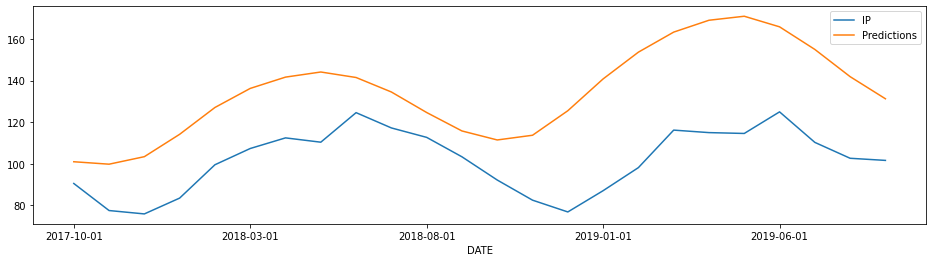

In [21]:
# Let´s plot the real values and the predictions

test_set.plot(figsize=(16,4));

In [23]:
# Now let´s calculate RSME

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_true=test_set["IP"], y_pred=test_set["Predictions"]))
rmse

35.91637427570589

In [24]:
ip_df.describe()

,IP
count,573.000000
mean,109.895545
std,27.950571
min,58.659800
25%,88.935500
50%,107.643000
75%,128.277700
max,196.173700
